Train network
===========

This script is based on a [jupyter notebook](https://nbviewer.jupyter.org/url/csbdeep.bioimagecomputing.com/examples/denoising3D/2_training.ipynb).
With this notebook you can train your own network after you have [created some training data](https://github.com/Rickmic/Deep_CLEM/blob/master/load_data.ipynb). <br/>
At first you have to import all required python packages:

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, ProjectionCARE

Using TensorFlow backend.


Execute the following cell to limit the GPU memory consumption to the half amount of the GPU memory. A limitation of the GPU memory is only neccessary, if there are other processes, that need also the GPU. If you are using the GPU only for the training of this network you do not need to execute the following cell.

In [2]:
limit_gpu_memory(fraction=1/2)

In the next step you have to specify the directory where your generated training data are located.

In [3]:
(X,Y), (X_val,Y_val), axes = load_training_data('/home/s353960/rickdata/F1 Praktikum/07_minimal_set_training/my_training_data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]


number of training images:	 576
number of validation images:	 64
image size (3D):		 (2, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1


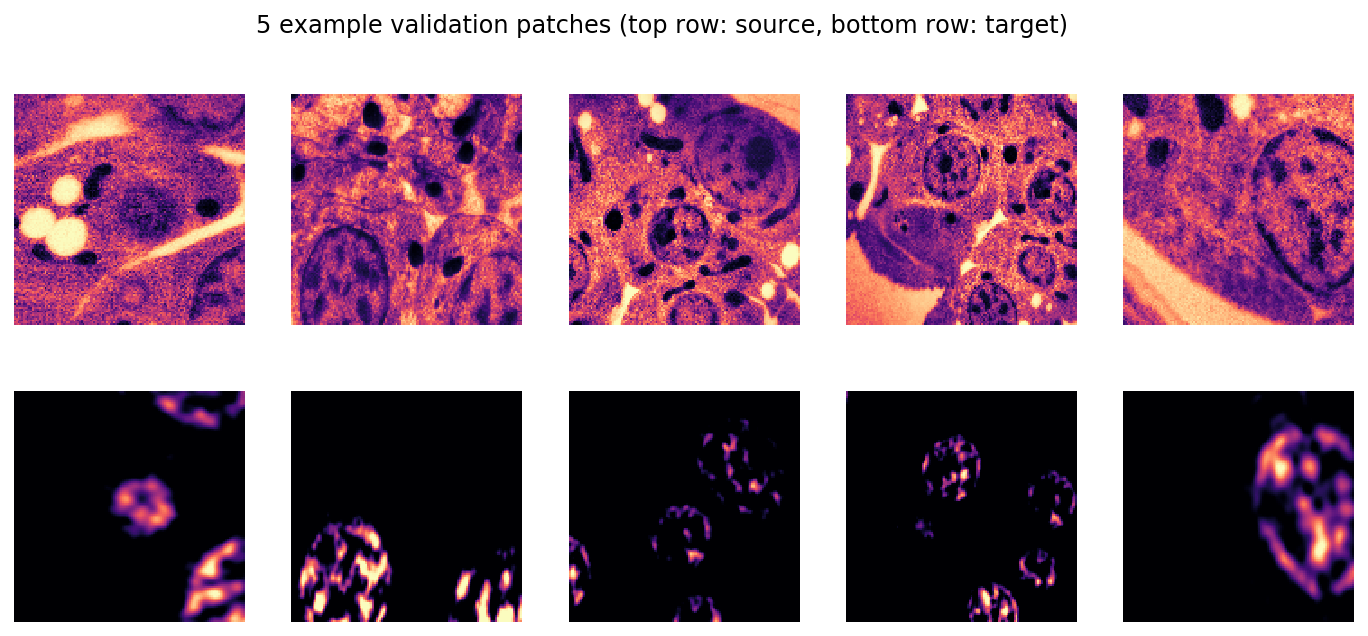

In [4]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');


In [5]:
config = Config(axes, n_channel_in, n_channel_out, unet_n_depth=3, train_batch_size=8, train_steps_per_epoch=800, train_epochs=150)
print(config)
vars(config)


Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=8, train_checkpoint='weights_best.h5', train_epochs=150, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=800, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 150,
 'train_steps_per_epoch': 800,
 'train_learning_rate': 0.0004,
 'train_batch_size': 8,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

Now you need to specify a directory, where a folder with the name *my_model* should be located. The trained network will be saved in this folder.

In [6]:
model = ProjectionCARE(config, 'my_model', basedir='/home/s353960/rickdata/F1 Praktikum/07_minimal_set_training/')

In [7]:


model.proj_params



ProjectionParameters(axis='Z', n_depth=4, n_filt=8, n_conv_per_depth=1, kern=(3, 3, 3), pool=(1, 2, 2))

With the following cell you will start the training process of the network. Depending on the GPU power and GPU memory this step will take 2-3 h.

In [8]:

history = model.train(X,Y, validation_data=(X_val,Y_val))



Epoch 1/150
800/800 [==============================] - 37s 46ms/step - loss: 0.0945 - mse: 0.0442 - mae: 0.0945 - val_loss: 0.0910 - val_mse: 0.0410 - val_mae: 0.0910
Epoch 2/150
800/800 [==============================] - 35s 44ms/step - loss: 0.0602 - mse: 0.0224 - mae: 0.0602 - val_loss: 0.0505 - val_mse: 0.0171 - val_mae: 0.0505
Epoch 3/150
800/800 [==============================] - 35s 43ms/step - loss: 0.0348 - mse: 0.0082 - mae: 0.0348 - val_loss: 0.0375 - val_mse: 0.0105 - val_mae: 0.0375
Epoch 4/150
800/800 [==============================] - 35s 44ms/step - loss: 0.0255 - mse: 0.0045 - mae: 0.0255 - val_loss: 0.0342 - val_mse: 0.0083 - val_mae: 0.0342
Epoch 5/150
800/800 [==============================] - 35s 43ms/step - loss: 0.0217 - mse: 0.0032 - mae: 0.0217 - val_loss: 0.0332 - val_mse: 0.0080 - val_mae: 0.0332
Epoch 6/150
800/800 [==============================] - 36s 45ms/step - loss: 0.0192 - mse: 0.0025 - mae: 0.0192 - val_loss: 0.0308 - val_mse: 0.0070 - val_mae: 0.030

Epoch 94/150
800/800 [==============================] - 40s 50ms/step - loss: 0.0039 - mse: 3.1929e-04 - mae: 0.0039 - val_loss: 0.0231 - val_mse: 0.0059 - val_mae: 0.0231
Epoch 95/150
800/800 [==============================] - 40s 50ms/step - loss: 0.0039 - mse: 3.1928e-04 - mae: 0.0039 - val_loss: 0.0231 - val_mse: 0.0059 - val_mae: 0.0231
Epoch 96/150
800/800 [==============================] - 40s 50ms/step - loss: 0.0039 - mse: 3.1769e-04 - mae: 0.0039 - val_loss: 0.0231 - val_mse: 0.0059 - val_mae: 0.0231
Epoch 97/150
800/800 [==============================] - 40s 50ms/step - loss: 0.0039 - mse: 3.1784e-04 - mae: 0.0039 - val_loss: 0.0231 - val_mse: 0.0059 - val_mae: 0.0231
Epoch 98/150
800/800 [==============================] - 40s 50ms/step - loss: 0.0039 - mse: 3.1908e-04 - mae: 0.0039 - val_loss: 0.0231 - val_mse: 0.0059 - val_mae: 0.0231
Epoch 99/150
800/800 [==============================] - 40s 50ms/step - loss: 0.0039 - mse: 3.1770e-04 - mae: 0.0039 - val_loss: 0.0231 - va

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


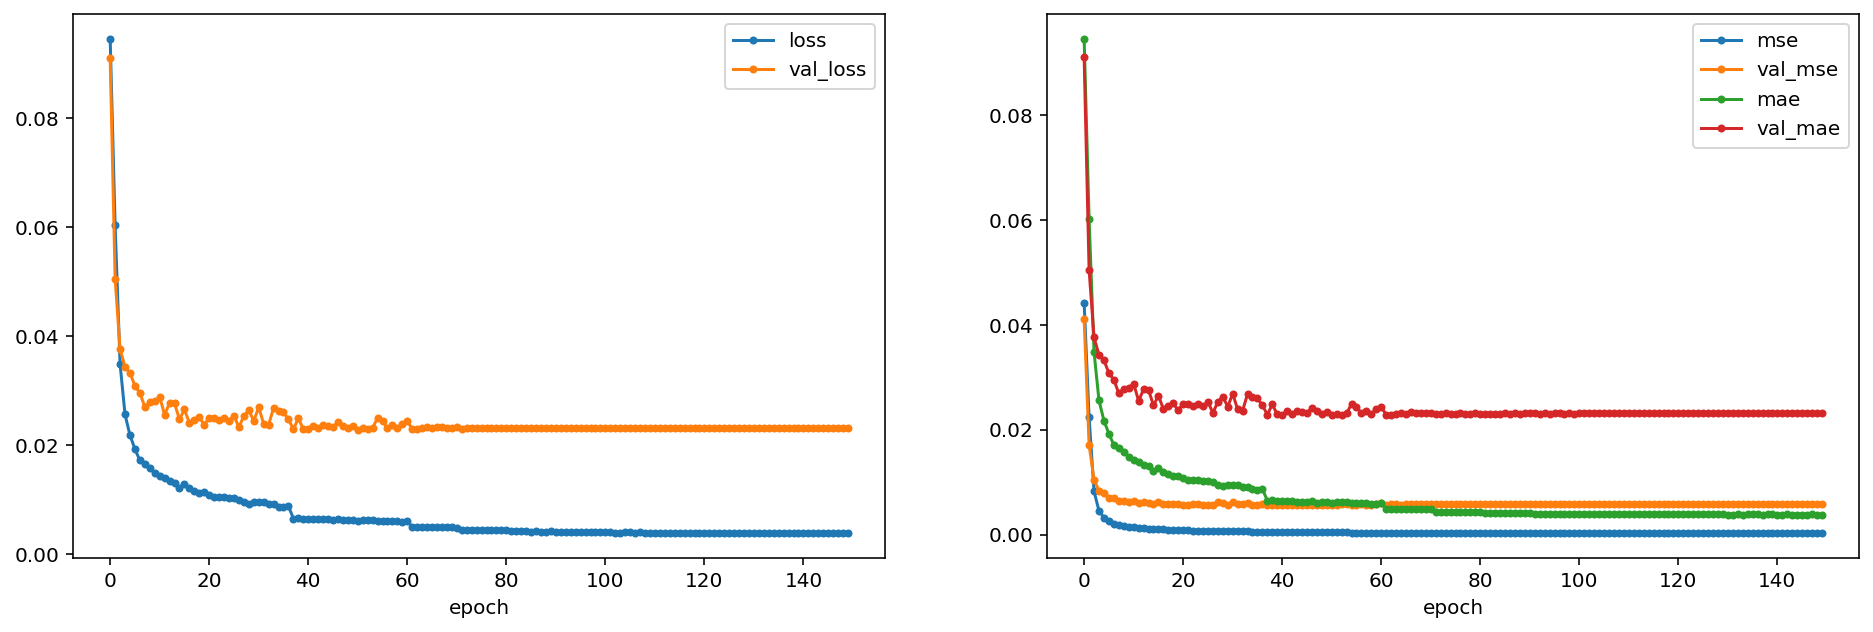

In [9]:


print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);



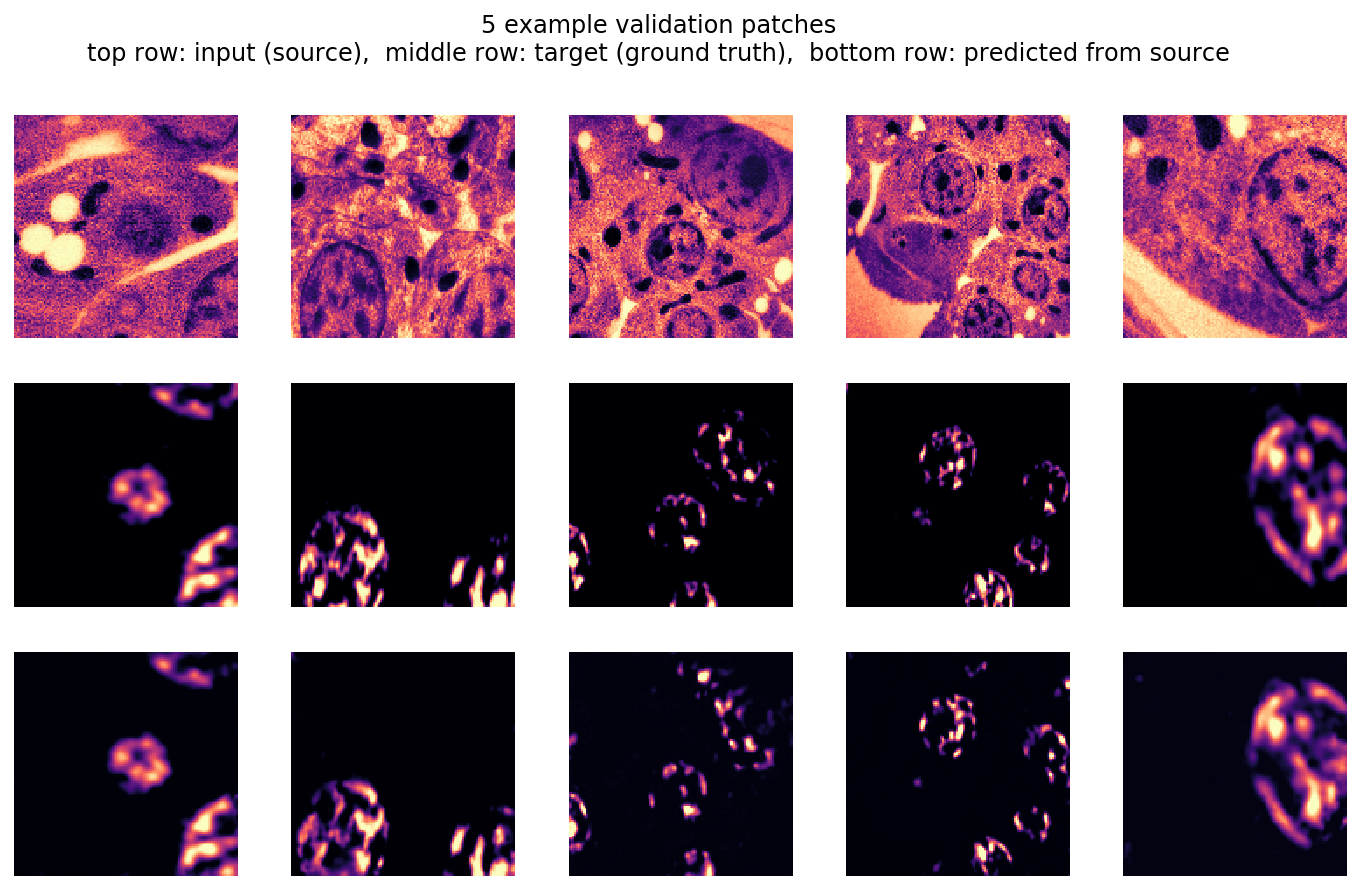

In [10]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');



In the last step you will save the network as a .zip file in the folder *my_model*. This .zip file contains the network, that you can load afterwards in Fiji.

In [11]:


model.export_TF()



INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmpg19qba4u/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/home/s353960/rickdata/F1 Praktikum/07_minimal_set_training/my_model/TF_SavedModel.zip
